In [ ]:
from IPython.display import HTML
HTML('''<h2>IMT 575: Sagemaker trial model</h2>
<b><pre>
    Authors: 
    Aftab Alam
    </pre>
</b> 
<p>Date/Time: <span id="datetime"></span></p><script>var dt = new Date();
document.getElementById("datetime").innerHTML=dt.toLocaleString();</script> </p>''')

In [ ]:
import sys
! conda install -y -c conda-forge ipywidgets
! pip install tldextract


In [1]:
import time
import sys
import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.predictor import csv_serializer

# enable flag to how all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/xgboost'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region, bucket)

In [3]:
%%time
# split data and save in s3

import io
import boto3
import random
from sklearn.model_selection import train_test_split

def appendXY(X,Y):
    df = pd.DataFrame(Y)
    print(df.shape)
    df.columns = ['Y']
    dfx = pd.DataFrame(X)
    print(dfx.shape)
    return pd.concat([df,dfx],axis=1)
   

def data_split(features,output_label,train_file, validation_file, test_file,test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(features, output_label, test_size=test_size, random_state=random_state)
    test_df = appendXY(X_test,y_test)
    test_df.to_csv(test_file,header=False,index=False)
    
    X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=test_size, random_state=random_state)
    train_df = appendXY(X_train,y_train)
    train_df.to_csv(train_file,header=False,index=False)
    
    valid_df = appendXY(X_test,y_test)
    valid_df.to_csv(validation_file,header=False,index=False)


def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 350 ms, sys: 31.8 ms, total: 381 ms
Wall time: 382 ms


In [4]:
# download file from S3
FILE_DATA = 'domainsDataSet'
s3 = boto3.client('s3')
s3.download_file(bucket, 'newDataSample.csv', FILE_DATA)

In [5]:
# Load the dataset
df_domains = pd.read_csv(FILE_DATA)

df_domains.tail()
df_domains.head()
df_domains.groupby('domain_type').agg('count')

,domain,domain_type
999995,kapital-rus.ru,benign
999996,kaufroboter.de,benign
999997,naikmotor.com,benign
999998,altengroup.sharepoint.com,benign
999999,icampusj.net,benign


,domain,domain_type
0,giamanek.com,benign
1,kennycason.com,benign
2,uniconbg.com,benign
3,ctnnbbrcuhusvjcdbypk.mx,dga
4,zhztea.com,benign


,domain
domain_type,
benign,499999
dga,500000


In [6]:
%%time
import tldextract

def extract_domain_subdomain(record):
    domain = record.domain
    ret=''
    try:
        ext = tldextract.extract(domain)
        ret = ext.domain
    except :
        print(record)
    return ret
def get_y(row):
    if row.domain_type.lower()=='dga':
        return 1
    elif row.domain_type.lower()=='benign':
        return 0
    else :
        return 1
    
df_domains.loc[:,'domain_subdomain'] = df_domains.apply(lambda row : extract_domain_subdomain(row), axis=1 )
## 1 for dga and 0 for benign
df_domains.loc[:,'Y'] = df_domains.apply(lambda row : get_y(row), axis=1 )

domain            NaN
domain_type    benign
Name: 765103, dtype: object
CPU times: user 1min 1s, sys: 170 ms, total: 1min 1s
Wall time: 1min 1s


In [12]:
VALID_CHARS = 'abcdefghijklmnopqrstuvwxyz0123456789-_.'
LOOKUP_TABLE = None
def pad(l, content, width):
        l.extend([content] * (width - len(l)))
        return l

def features_extract(domain): 
    
    global VALID_CHARS    
    global LOOKUP_TABLE    
    if not LOOKUP_TABLE:        
        LOOKUP_TABLE = dict()       
        idx = 1
        for c in VALID_CHARS:
            LOOKUP_TABLE[c] = int(idx)            
            idx += int(1)    
    #ds = tldextract.extract(fqdn)    
    #domain = ds.domain 
       
    rvalue = list()  
    if len(domain)<=63 and ' ' not in domain:
        for c in domain.lower():        
            rvalue.append(LOOKUP_TABLE[c])
    else: 
        #print(domain)
        pass
            
    rvalue=pad(rvalue,0,63)    
    return rvalue


In [8]:
## tldextract example
url = 'https://www.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcde.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.com'
ext=tldextract.extract(url)
ext
features_extract(ext.domain).shape


ExtractResult(subdomain='www.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcde.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk', domain='abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk', suffix='com')

(63,)

In [13]:
# features X vector
X = [features_extract(D) for D in df_domains.domain_subdomain]
X = np.array(X)
X.shape


(1000000, 63)

In [ ]:
df_domains.head(11).tail()

In [ ]:
X1=np.array([[12,3,4],[12,3,4]])

In [ ]:
X

In [15]:
%%time
# split df in training , validation and test and save as file
FILE_TRAIN = 'domainsDataSet.train'
FILE_VALIDATION = 'domainsDataSet.validation'
FILE_TEST = 'domainsDataSet.test'

data_split(features=X,output_label=df_domains['Y'].values,train_file=FILE_TRAIN
           ,validation_file=FILE_VALIDATION, test_file=FILE_TEST,test_size=0.2, random_state=42)

#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)


(200000, 1)
(200000, 63)
(640000, 1)
(640000, 63)
(160000, 1)
(160000, 63)
Writing to s3://sagemaker-us-west-2-099176660580/sagemaker/xgboost/train/domainsDataSet.train
Writing to s3://sagemaker-us-west-2-099176660580/sagemaker/xgboost/validation/domainsDataSet.validation
Writing to s3://sagemaker-us-west-2-099176660580/sagemaker/xgboost/test/domainsDataSet.test
CPU times: user 1min 2s, sys: 977 ms, total: 1min 3s
Wall time: 1min 5s


In [16]:
!head -3 domainsDataSet.validation

1,6,8,19,7,6,16,1,3,18,15,7,5,17,16,12,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,3,3,1,19,9,15,14,19,1,9,12,18,5,12,1,24,18,5,17,21,9,18,5,19,3,8,5,13,5,1,16,16,18,5,3,9,1,20,5,7,18,1,19,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17,7,18,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
print('test data')
!head -3 domainsDataSet.test
print('train data')
!head -3 domainsDataSet.train

test data
0,9,20,4,1,9,12,25,4,15,3,21,13,5,14,20,1,20,9,15,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,17,18,19,9,10,15,10,23,22,9,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,22,9,12,12,1,7,5,23,15,21,12,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train data
1,2,14,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20,14,20,7,18,15,21,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,13,15,19,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# if train and test data is already saved repeat from here.

In [18]:
# create input
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

In [19]:
%%time
# train model
from sagemaker.amazon.amazon_estimator import get_image_uri
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name


container = get_image_uri(region, 'xgboost','0.90-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

# fitting model with default parameters
xgb.set_hyperparameters(base_score=0.5, 
                        booster='gbtree', #['gbtree', 'gblinear', 'dart']
                        colsample_bylevel=1,
                        colsample_bynode=1, 
                        colsample_bytree=1, 
                        gamma=0, 
                        max_delta_step=0, max_depth=6,
                        min_child_weight=1,
                        alpha=0,
                        scale_pos_weight=1, subsample=1, tree_method='auto',
                        eta=0.3,
                        silent=1,
                        objective='binary:logistic',
                        num_round=400,
                        eval_metric='error')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-05-07 23:34:21 Starting - Starting the training job...
2020-05-07 23:34:22 Starting - Launching requested ML instances......
2020-05-07 23:35:24 Starting - Preparing the instances for training......
2020-05-07 23:36:27 Downloading - Downloading input data...
2020-05-07 23:36:53 Training - Downloading the training image...
2020-05-07 23:37:28 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter tree_method value auto to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value error to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter booster value gbtree to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No G

[99]#011train-error:0.065977#011validation-error:0.06685
[100]#011train-error:0.065948#011validation-error:0.066875
[101]#011train-error:0.065892#011validation-error:0.066856
[102]#011train-error:0.065477#011validation-error:0.066463
[103]#011train-error:0.065331#011validation-error:0.066238
[104]#011train-error:0.065023#011validation-error:0.065819
[105]#011train-error:0.064923#011validation-error:0.065788
[106]#011train-error:0.064595#011validation-error:0.065625
[107]#011train-error:0.064536#011validation-error:0.065506
[108]#011train-error:0.064141#011validation-error:0.065194
[109]#011train-error:0.064116#011validation-error:0.065194
[110]#011train-error:0.064078#011validation-error:0.065169
[111]#011train-error:0.064048#011validation-error:0.065181
[112]#011train-error:0.063581#011validation-error:0.064737
[113]#011train-error:0.063408#011validation-error:0.064731
[114]#011train-error:0.063234#011validation-error:0.06455
[115]#011train-error:0.063164#011validation-error:0.064475


[231]#011train-error:0.049888#011validation-error:0.054144
[232]#011train-error:0.049817#011validation-error:0.0542
[233]#011train-error:0.049645#011validation-error:0.054113
[234]#011train-error:0.049628#011validation-error:0.054
[235]#011train-error:0.04962#011validation-error:0.054
[236]#011train-error:0.04952#011validation-error:0.0539
[237]#011train-error:0.049466#011validation-error:0.053863
[238]#011train-error:0.049345#011validation-error:0.053875
[239]#011train-error:0.049331#011validation-error:0.053863
[240]#011train-error:0.049275#011validation-error:0.053694
[241]#011train-error:0.049147#011validation-error:0.053644
[242]#011train-error:0.049048#011validation-error:0.053669
[243]#011train-error:0.048889#011validation-error:0.053531
[244]#011train-error:0.048792#011validation-error:0.053469
[245]#011train-error:0.048722#011validation-error:0.053494
[246]#011train-error:0.048641#011validation-error:0.053425
[247]#011train-error:0.048558#011validation-error:0.053287
[248]#011

[363]#011train-error:0.041364#011validation-error:0.048369
[364]#011train-error:0.041258#011validation-error:0.048381
[365]#011train-error:0.041225#011validation-error:0.048369
[366]#011train-error:0.041164#011validation-error:0.048256
[367]#011train-error:0.041148#011validation-error:0.048244
[368]#011train-error:0.041142#011validation-error:0.048344
[369]#011train-error:0.041103#011validation-error:0.048338
[370]#011train-error:0.041086#011validation-error:0.048256
[371]#011train-error:0.041039#011validation-error:0.048313
[372]#011train-error:0.040934#011validation-error:0.048262
[373]#011train-error:0.040866#011validation-error:0.048262
[374]#011train-error:0.04087#011validation-error:0.048313
[375]#011train-error:0.040767#011validation-error:0.048225
[376]#011train-error:0.040672#011validation-error:0.048231
[377]#011train-error:0.040614#011validation-error:0.048138
[378]#011train-error:0.040558#011validation-error:0.0481
[379]#011train-error:0.040519#011validation-error:0.048106


In [20]:
!pip install pickle-mixin
!pip install xgboost==0.90

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
import tarfile
import pickle as pkl

path_key = f'{prefix}/output/sagemaker-xgboost-2020-05-07-23-34-21-072/output'
# download the model artifact from AWS S3
s3 = boto3.client('s3')
s3.download_file(bucket, f'{path_key}/model.tar.gz', 'model.tar.gz')

! ls -lrt


#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
file = open('xgboost-model', 'rb')
model = pkl.loads(file.read())

total 344292
-rw-r--r-- 1 ec2-user ec2-user     41578 May  7 12:35 xgboost-model
-rw-rw-r-- 1 ec2-user ec2-user     38471 May  7 15:34 Build-and-Deploy-DGA.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 185679638 May  7 15:51 dataset.csv
-rw-rw-r-- 1 ec2-user ec2-user       146 May  7 17:58 single.test
-rw-rw-r-- 1 ec2-user ec2-user  31112070 May  7 23:27 domainsDataSet
-rw-rw-r-- 1 ec2-user ec2-user  26986150 May  7 23:32 domainsDataSet.test
-rw-rw-r-- 1 ec2-user ec2-user  86348628 May  7 23:33 domainsDataSet.train
-rw-rw-r-- 1 ec2-user ec2-user  21588916 May  7 23:33 domainsDataSet.validation
-rw-rw-r-- 1 ec2-user ec2-user     78730 May  7 23:46 Build-deploy-dga-xgboost.ipynb
-rw-rw-r-- 1 ec2-user ec2-user    657885 May  7 23:46 model.tar.gz


In [40]:
!head -1 domainsDataSet.test > single.test

In [ ]:
import xgboost
with open('single.test', 'r') as f:
    payload = f.read().strip()
    print(payload)
    dtrain = xgboost.DMatrix(payload[2:], label=payload[0])
model.predict(dtrain)

Text(0.5, 1.0, 'Feature Importance')

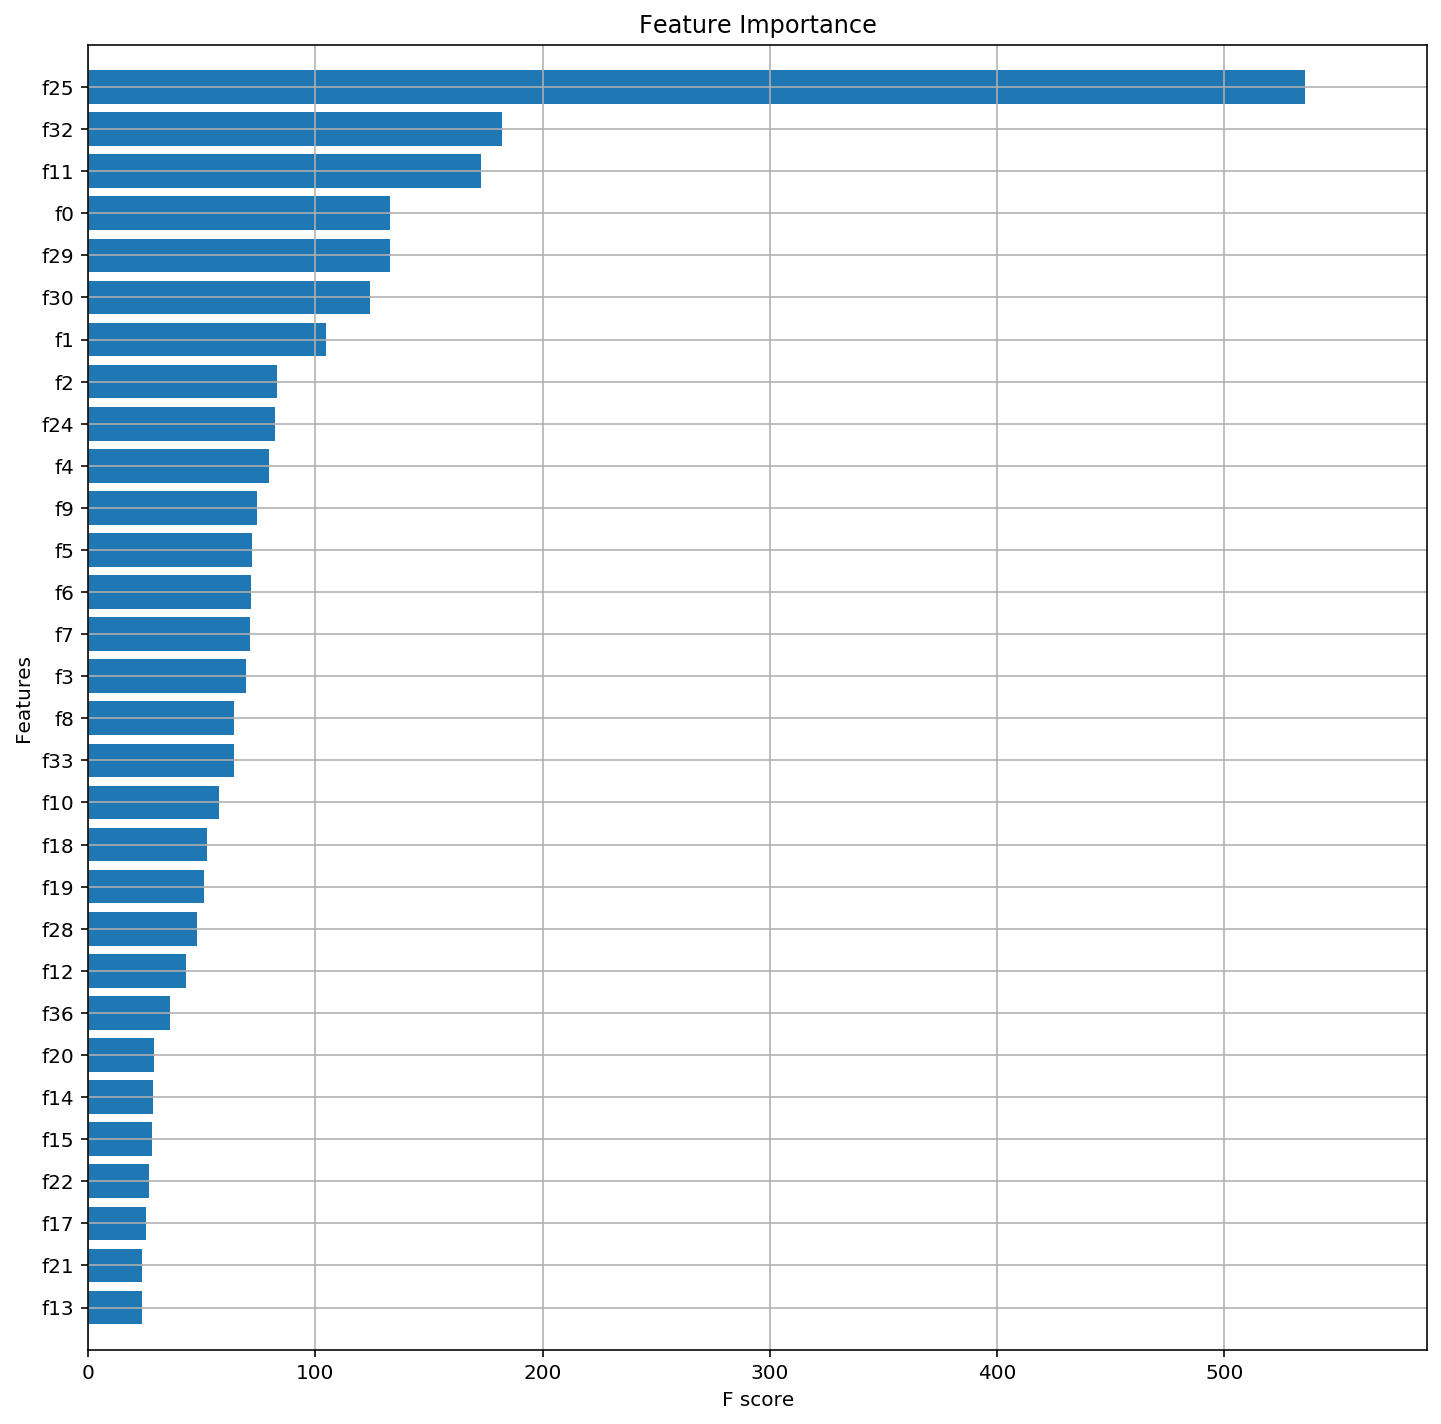

In [30]:
import xgboost
map_names = dict(zip(model.feature_names, df_domains.columns))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

In [31]:
## Deploy trained XGBoost model endpoint to perform predictions
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')





-----------------!

In [32]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None


In [33]:
!head -10 domainsDataSet.test > single.test

In [34]:
## Function to chunk down test set into smaller increments

def predict(data, model, rows=500):
    split_array = np.array_split(data, int(len(data) / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

## Generate predictions on the test set for the difference models
with open('single.test', 'r') as f:
    payload = f.read().strip()
labels = [int(line.split(',')[0]) for line in payload.split('\n')]
test_data = [line.split(',')[2:] for line in payload.split('\n')]
predictions = predict(test_data, xgb_predictor)
#xgb_predictor.predict(payload[2:]).decode('utf-8')
predictions

array([0.08778916, 0.99848866, 0.32659611, 0.97878689, 0.99056482,
       0.99991417, 0.73356611, 0.39678892, 0.34731829, 0.99987197])

In [35]:
## Generate predictions on the test set for the difference models
with open('domainsDataSet.test', 'r') as f:
    payload = f.read().strip()
labels = [int(line.split(',')[0]) for line in payload.split('\n')]
test_data = [line.split(',')[2:] for line in payload.split('\n')]
predictions = predict(test_data, xgb_predictor)
#xgb_predictor.predict(payload[2:]).decode('utf-8')
from sklearn.metrics import accuracy_score ,confusion_matrix
thresh = 0.5
y_pred = predictions
y_pred_binary = np.where(predictions > thresh, 1, 0)
accuracy_score(labels,y_pred_binary)
confusion_matrix(labels,y_pred_binary)

0.905165

array([[94147,  5607],
       [13360, 86886]])

In [36]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'colsample_bylevel': ContinuousParameter(0.1, 1,scaling_type="Logarithmic"),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

objective_metric_name = 'validation:accuracy'

tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=60,
    max_parallel_jobs=3,
    strategy='Bayesian'
)

## Starts the hyperparameter tuning job
tuner_log.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [ ]:
client_sag= boto3.client('sagemaker')
status = client_sag.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(600)
    status =  client_sag.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
    print(status)

In [ ]:
# get the best performance model job and create endpoint and then predict using test data

In [ ]:
# Import model for hosting

%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

In [ ]:
# create endpoint configuration
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':"ml.m5.large",
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

In [45]:
%%time
# create end point


import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
while status=='Creating':
    print("Status: " + status)
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

NameError: name 'strftime' is not defined

In [46]:
# load test data from assignment and write function to test one record at a time